# Prerequisites

## Packages

In [33]:
!pip install -U accelerate peft transformers einops datasets bitsandbytes
!pip install -U matplotlib
# !pip install nbconvert

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [34]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

accelerate==0.28.0
bitsandbytes==0.43.0
datasets==2.18.0
einops==0.7.0
peft==0.9.0
torch==2.2.1
transformers==4.39.0


## Set a seed for reproducibility of the training process

In [35]:
from transformers import set_seed

set_seed(42)

# Load model and tokenizer

## Load model in 4 bit

In [36]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
    # FA2 does not work yet
    # attn_implementation="flash_attention_2",          
)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


In [37]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_la

## Load tokenizer

In [38]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)    # fast tokenizer sometimes ignores the added tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [39]:
len(tokenizer)

50295

## Add ChatML tokens to tokenizer

In [40]:
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings. 

In [41]:
model.model.embed_tokens

Embedding(51200, 2560)

## Prepare LoRA adapters

In [42]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) 

lora_config = LoraConfig(
    r=32, 
    lora_alpha=32, 
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    modules_to_save = ["lm_head", "embed_tokens"],
    lora_dropout=0.1, 
    bias="none", 
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

model.config.use_cache = False

# Load and preprocess dataset

In [43]:
from datasets import load_dataset

dataset = load_dataset("nikad/riddles_evolved")
dataset = dataset["train"].train_test_split(test_size=0.1)

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 1543
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 172
    })
})

In [21]:
dataset["train"][0]

{'number': 1070,
 'messages': ['What can be broken, but never wounded?',
  'The answer to this riddle is "an egg." An egg can be broken by applying force to the shell, causing it to crack and split, but the contents inside, the yolk and white, are not wounded in the same way a living being would be when injured.',
  "Wow, that's cool! So what's something that's always cold but can also be hot?",
  'The answer to this riddle is "ice." Ice is a frozen form of water and is naturally cold. However, when ice melts and turns into water, it can be heated and become hot. Additionally, ice can be used to cool down hot objects or beverages, or it can be used in the production of cold beverages like ice cream, but the substance itself can also be a component in hot beverages like hot chocolate or ice coffee.']}

## Apply ChatML format and tokenize

In [46]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []

    for i,msg in enumerate(input["messages"]):
        isHuman = i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=1024), # max sample length 1024 tokens, enough for this dataset
    batched=False, 
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

longest sample: 875 tokens


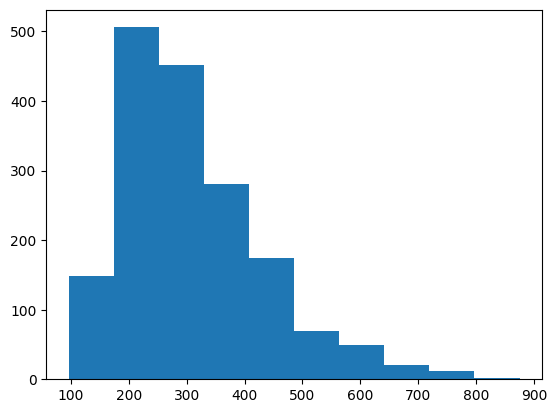

In [47]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])] 
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)  
plt.show()

## Define a collate function, train on answers only

In [48]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )   
        labels.extend( pad_len * [IGNORE_INDEX] )    
        attention_mask.extend( pad_len * [0] ) 

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch

# Train

## Set hyperparameters

In [49]:
from transformers import TrainingArguments, Trainer

# dataset-specific parameters
bs=1     # batch size for training
bs_eval=16    # batch size for evaluation
ga_steps=16  # gradient accumulation steps
lr=0.00002  # learning rate
epochs=20

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="/code/out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,        
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

In [50]:
!pip install -U wandb

Defaulting to user installation because normal site-packages is not writeable


In [51]:
# log to a specific wandb project
import os
os.environ["WANDB_PROJECT"] = "phi2"
os.environ["WANDB_API_KEY"] = "b6eeec460a9c43c95b0df8e8c571e6f3cc09c736"
import wandb 
run = wandb.init(
    project="phi2",
    name="testrun",
)

AttributeError: module 'wandb' has no attribute 'init'

## Start training

In [31]:
trainer.train()

: 

/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


# After training: Merge LoRA adapters with base model

In [33]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path="microsoft/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="/code/out/checkpoint-1920" 

# where to save merged model
save_to="/code/out/trained_model"       

# Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100, 
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Inference of trained model

In [36]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="/code/out/trained_model"    
question="A bird is built without me. I have to be broken to let water out. What am I?"

model = AutoModelForCausalLM.from_pretrained(
        model_path,    
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path) 

messages=[
    {"role": "user", "content": question}
]
        
input_tokens = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )               

print(output)

Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The answer to the riddle is a "glass". A glass is made by melting sand and other ingredients together, then cooling it down so that it becomes solid but still allows liquids like water or air to pass through it when it's not completely full. If you need more information about glasses or if there's anything else I can help with, please ask!


# Upload model to hub

In [37]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
# from transformers 

# Load model and tokenizer
modelpath="/code/out/trained_model"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(modelpath) 

# Upload
model.push_to_hub("nikad/phi-2_riddles-evolved")
tokenizer.push_to_hub("nikad/phi-2_riddles-evolved")

Loading checkpoint shards:   0%|                                                                                     | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
model-00002-of-00002.safetensors:   0%|                                                                         | 0.00/564M [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   1%|▌                                                               | 4.70M/564M [00:01<01:34, 5.89MB/s]
model-00002-of-00002.safetensors:   1%|▋                                                               | 6.11M/564M [00:01<01:27, 6.38MB/s]
model-00002-of-00002.safetensors:   1%|▉                                                               | 7.91M/564M [00:01<01:15, 7.40MB/s]
model-00002-of-00002.safetensors:   3%|█▌                                                              | 14.1M/564M [00:02<01:00, 9.12MB/s]

model-00002-of-00002.safetensors:   4%|█